In [4]:
import numpy as np
import pandas as pd


%matplotlib inline 

import cv2
import matplotlib.pyplot as plt
import os


In [5]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1


In [6]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense


In [7]:
!pip install keras

In [8]:
resnet_weights_path = 'resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [9]:
print(resnet_weights_path)

resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
ls

best.hdf5  resnet50/  test/  train/  TransferLearning.ipynb  valid/  working/


In [10]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False


W0823 14:01:43.574665 139662678230848 deprecation.py:506] From /home/srijana/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [10]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

Using TensorFlow backend.


In [22]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [24]:
train_generator = train_datagen.flow_from_directory(
    directory=r"./train/",
    target_size=(image_size, image_size),
    color_mode="rgb",
    
    class_mode="categorical",
    shuffle=True,
    
    batch_size=BATCH_SIZE_VALIDATION
)

Found 20000 images belonging to 2 classes.


In [25]:
valid_generator = train_datagen.flow_from_directory(
    directory=r"./valid/",
    target_size=(image_size, image_size),
    color_mode="rgb",
    
    class_mode="categorical",
    shuffle=True,
    
    batch_size=BATCH_SIZE_VALIDATION
)

Found 5000 images belonging to 2 classes.


In [26]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(valid_generator))

(100, 200, 100, 50)

In [17]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [18]:
!pip install sklearn

In [20]:
!mkdir working

In [26]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=valid_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.save_weights("../best.hdf5")


Epoch 1/10
10/10 [==============================] - 175s 18s/step - loss: 0.0525 - acc: 0.9860 - val_loss: 0.0804 - val_acc: 0.9770
Epoch 2/10
10/10 [==============================] - 173s 17s/step - loss: 0.0417 - acc: 0.9820 - val_loss: 0.0747 - val_acc: 0.9770
Epoch 3/10
10/10 [==============================] - 166s 17s/step - loss: 0.0409 - acc: 0.9860 - val_loss: 0.0978 - val_acc: 0.9750
Epoch 4/10
10/10 [==============================] - 165s 16s/step - loss: 0.0546 - acc: 0.9800 - val_loss: 0.0787 - val_acc: 0.9780
Epoch 5/10
10/10 [==============================] - 157s 16s/step - loss: 0.0579 - acc: 0.9800 - val_loss: 0.0938 - val_acc: 0.9740


In [27]:


print(fit_history.history.keys())



dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


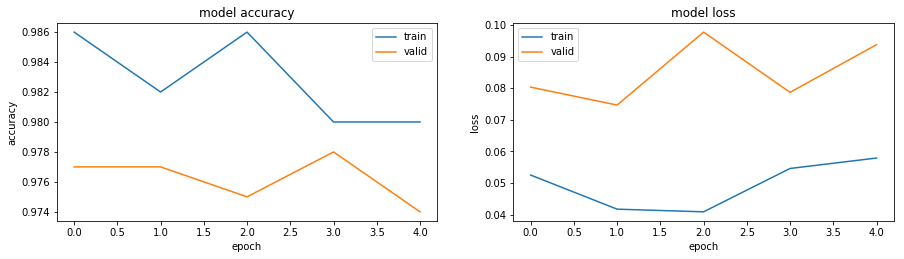

In [28]:
 
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()



In [59]:
ls

catsdogs-trainvalid-80pc-prepd/  test-files-prepd/       working1/
resnet50/                        TransferLearning.ipynb


In [31]:

test_generator = train_datagen.flow_from_directory(
    directory=r"./test/",
    target_size=(image_size, image_size),
    color_mode="rgb",
    batch_size=BATCH_SIZE_TESTING,
    class_mode=None,
    shuffle=False,
    seed=123
)

# ??train_datagen.flow_from_directory

Found 12500 images belonging to 1 classes.


In [34]:
ls

best.hdf5  resnet50/  test/  train/  TransferLearning.ipynb  valid/  working/


In [36]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)


12500/12500 [==============================] - 1112s 89ms/step


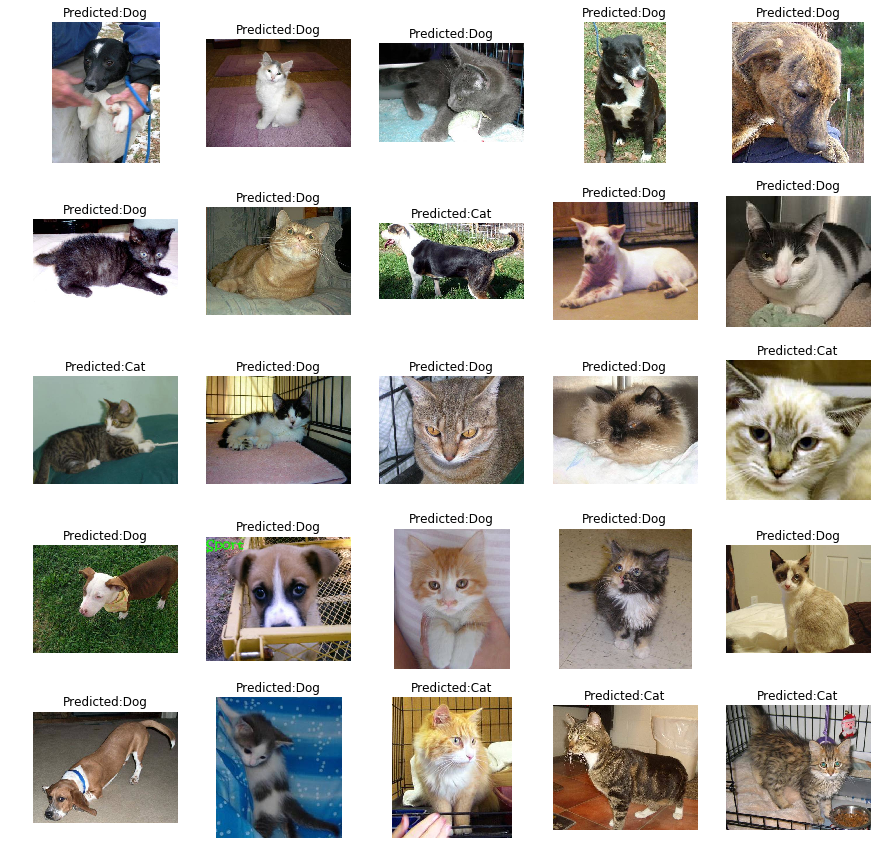

In [37]:
TEST_DIR = 'test/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()